# Bifdflow: Learning Bird Population Flows from Citizen Science Data
## Authors: Miguel Fuentes, Benjamin Van Doren, Daniel Fink, Daniel Sheldon
![schematic](schematic_2-01.png)
This demonstration will give an example for how to train a birdflow model and generate results from it

# Step 1: Load and Process Data

In [1]:
import numpy as np
import rasterio

tif_path = "amewoo-moll-2019-croptoextent-100.tif"

# we use rasterio to read the tif file containing the abundance date for the american woodcock
with rasterio.open(tif_path) as src:
    data_array = src.read()

# the tif saves nan values as a large negative number, here we reset them to the numpy nan value
NDV = -3.3e+38
data_array[data_array<=NDV] = np.nan

print("data array shape: ", data_array.shape)

data array shape:  (52, 45, 51)


In [2]:
from flow_model_training import Datatuple, process_data

true_densities, dtuple = process_data(data_array)

# process data flattens the map to 1D, removes the NaN cells (unmodeled area), and normalizes the abundance
print("true densities shape:", true_densities.shape)

# process data also returns a datatuple which contains helpful information about the data
print("Fields in the Datatuple:")
for f in dtuple._fields:
    print("\t", f)

true densities shape: (52, 1706)
Fields in the Datatuple:
	 weeks
	 x_dim
	 y_dim
	 cells
	 nan_mask


# Step 2: Train the Model

In [3]:
from flow_model_training import gen_d_matrix, loss_fn
from jax import jit
from functools import partial

obs_weight, dist_weight, ent_weight, dist_pow = 1.0, 5.0e-3, 1.125e-3, 0.45

# Generate the distance Matrix
d_matrix = gen_d_matrix(dtuple.x_dim, dtuple.y_dim, dtuple.nan_mask)
d_matrix = d_matrix ** dist_pow

# Instantiate loss function and apply just in time compilation (jit) to speedup
loss_fn = jit(partial(loss_fn, 
                      true_densities=true_densities, 
                      d_matrix=d_matrix, 
                      obs_weight=obs_weight, 
                      dist_weight=dist_weight,
                      ent_weight=ent_weight))

In [4]:
from flow_model_training import train_model
from haiku import PRNGSequence
from optax import adam

rng_seed, learning_rate, training_steps = 42, 0.1, 1000

# Get the random seed and optimizer
key = PRNGSequence(rng_seed)
optimizer = adam(learning_rate)

# Run Training and get params and losses
params, loss_dict = train_model(loss_fn,
                                optimizer,
                                training_steps,
                                dtuple.cells,
                                dtuple.weeks,
                                key)

# Step 3: Query Model

In [5]:
from flow_model import get_prob

# use this to query the model for the probability of a particular transition, can be used to calculate ALL
week = 7
loc1 = 105
loc2 = 105
print(f"the probability that a bird which is in cell {loc1} during week {week} is in cell {loc2} in week {week + 1}: ", get_prob(params, week, loc1, loc2))

the probability that a bird which is in cell 105 during week 7 is in cell 105 in week 8:  0.19709036


# Step 4: Make Forecast

In [6]:
from flow_model import gen_shift_list

# Since we remove non-terrestrial cells from our model, we need to shift the indices to add the water cells for plotting
shift_list = gen_shift_list(dtuple.nan_mask)
reverse_shifts = {i + shift : i for i, shift in enumerate(shift_list)}

In [7]:
from flow_model import project_density, shift_density
import jax.numpy as jnp
from jax.ops import index_add, index_update, index

# We are going to forecast from this position
week1, loc1, row1, col1 = 4, 1751, 34, 17
week2 = 13

# Create an initial distribution
shifted_start = reverse_shifts[loc1]
init_dist = index_update(jnp.zeros(dtuple.cells), index[shifted_start], 1.0)

# Apply model transitions
init, flow = project_density(params, init_dist, t_start=week1, t_end=week2)
densities = jnp.array([init_dist] + [f.sum(axis=0) for f in flow])

# Shift to map indices
shifted_densities = shift_density(densities, dtuple.nan_mask, dtuple.x_dim, dtuple.y_dim)

# Isolate and reshape final distribution
shifted_final = shifted_densities[-1]
final = shifted_final.reshape(dtuple.y_dim, dtuple.x_dim)

Text(0.5, 1.0, 'Model Forecast vs True Transition')

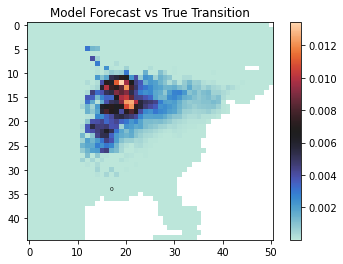

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Show Initial Position and Forecasted Distribution
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(final, cmap='icefire')
plt.colorbar()
ax.text(col1,
         row1,
         '0',
          fontsize=6,
         horizontalalignment='center',
         verticalalignment='center')

ax.set_title("Model Forecast vs True Transition")